In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Charger et explorer les données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

In [62]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/marketing_campaign.csv', sep='	')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


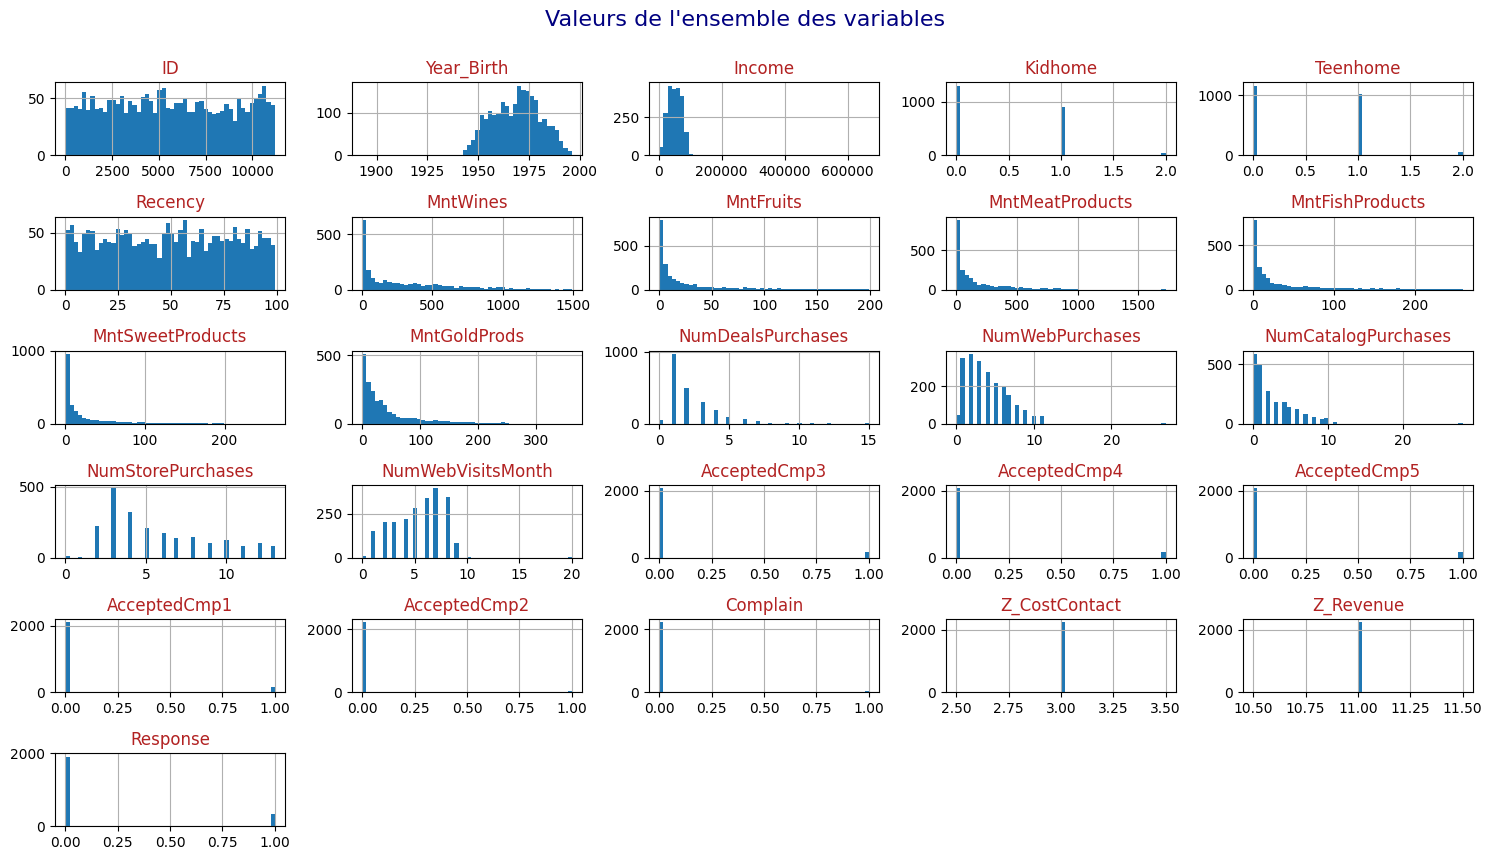

In [63]:
axes = df.hist(bins=50, figsize=(15,9))
plt.suptitle("Valeurs de l'ensemble des variables", fontsize=16, color="navy")
for ax in axes.ravel():
    ax.set_title(ax.get_title(), color='firebrick')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Cleaning & Outliers

String to categorical

In [64]:
education_map = {
    '2n Cycle': 1,
    'Basic': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
marital_map = {
    'Single': 1,
    'Divorced': 1,
    'Widow': 1,
    'Together': 2,
    'Married': 2,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}
df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)
df.shape

(2240, 29)

String(date) to int

In [65]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_For_Days'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns='Dt_Customer', inplace=True)
df.shape

(2240, 29)

In [66]:
df = df[
    (df['Year_Birth'] > 1930) &
    (df['Income'] < 140000) &
    (df['MntMeatProducts'] < 1250) &
    (df['MntGoldProds'] < 300) &
    (df['MntSweetProducts'] < 300) &
    (df['NumWebPurchases'] < 15) &
    (df['NumCatalogPurchases'] < 15) &
    (df['NumWebVisitsMonth'] < 15)
]
df = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])
df.shape

(2195, 26)

In [67]:
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df.select_dtypes(include=[np.number]))
df['Outlier_IForest'] = outlier_pred
print(df['Outlier_IForest'].value_counts())
df = df[df['Outlier_IForest'] == 1].drop(columns='Outlier_IForest')
df.shape

Outlier_IForest
 1    2085
-1     110
Name: count, dtype: int64


(2085, 26)

- Features division

In [68]:
extract_x_continuous = df[['Year_Birth', 'Income', 'Recency', 'MntWines',
'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
'NumCatalogPurchases', 'NumStorePurchases',
'NumWebVisitsMonth', 'Customer_For_Days', 'MntFruits',
'MntMeatProducts',
'MntFishProducts',
'MntSweetProducts']]
extract_x_continuous.shape

(2085, 15)

? Kidhome & Teenhome sont des variables catégoriels ou Continues ?

In [69]:
extract_x_cat = df[['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 
'AcceptedCmp2', 'Complain', 'Response']]
extract_x_cat.shape

(2085, 11)

## Feature engenering

### Continuous features

Faire une corrélation de Pearson puis faire un CAH pour faire du feature engenering

? Enlever Year_Birth ?

In [70]:
df_num = pd.DataFrame(extract_x_continuous)
df_num['Age'] = 2024 - df_num['Year_Birth']

purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 
                'NumStorePurchases', 'NumDealsPurchases']
df_num['Total_Purchases'] = df_num[purchase_cols].sum(axis=1)

df_num['MntFoodTotal'] = df_num[['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
df_num.drop(columns=['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts'], inplace=True)

df_num.shape

(2085, 14)

In [71]:
print('Before F.E : ', extract_x_continuous.shape[1])
print('After F.E : ', df_num.shape[1])

Before F.E :  15
After F.E :  14


### Categorical features

In [72]:
print('Before F.E : ', extract_x_cat.shape[1])
df_cat = pd.DataFrame(extract_x_cat)
df_cat['Children']=df_cat['Kidhome']+df_cat['Teenhome']

print('After F.E : ', df_cat.shape[1])

Before F.E :  11
After F.E :  12


## PCA

In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_num.columns, index=df_num.index)

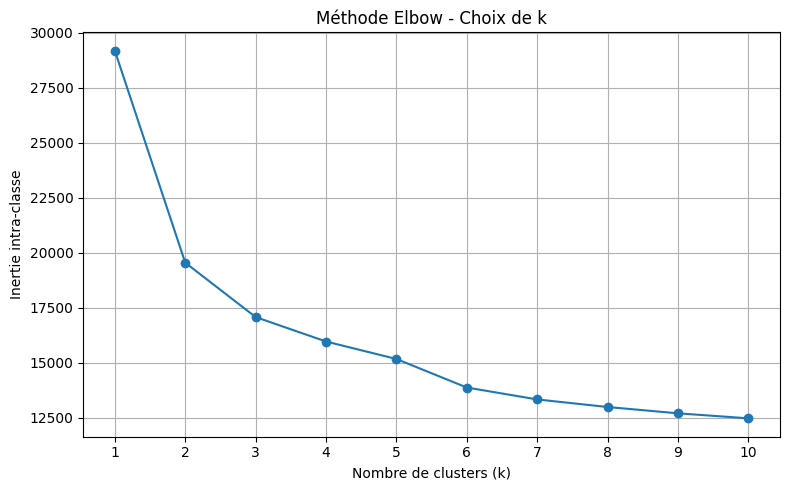

In [74]:
inertias = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled_df)
    inertias.append(model.inertia_)

# Affichage du coude
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode Elbow - Choix de k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-classe")
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled_df)

In [88]:
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(X_scaled_df)
print('Nombre de composantes conservées :', pca.n_components_)

Nombre de composantes conservées : 7


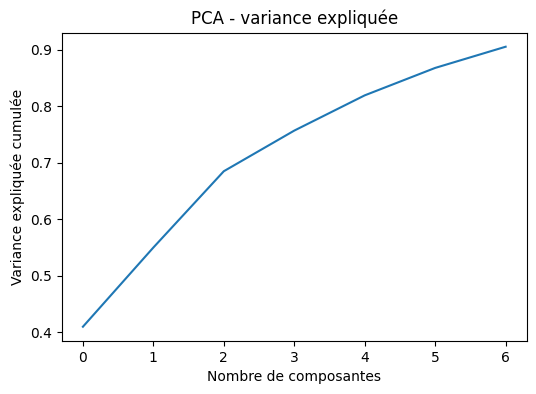

In [89]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

### 2D

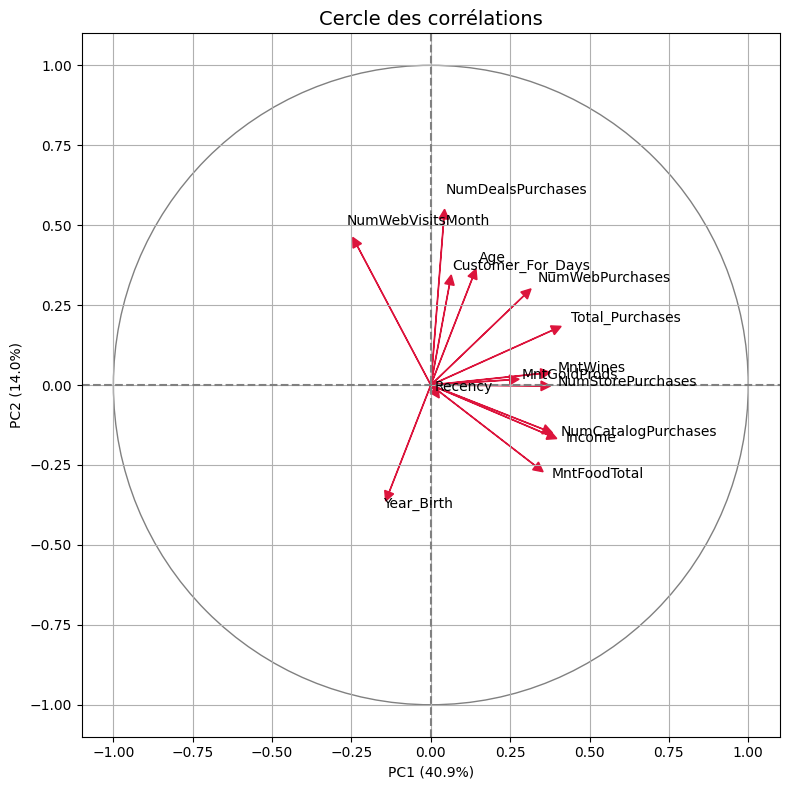

In [90]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax.add_artist(circle)

pc1 = pca.components_[0]
pc2 = pca.components_[1]

for i in range(len(X_scaled_df.columns)):
    x, y = pc1[i], pc2[i]
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='crimson', ec='crimson')
    ax.text(x * 1.15, y * 1.15, X_scaled_df.columns[i], fontsize=10)

ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Cercle des corrélations", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


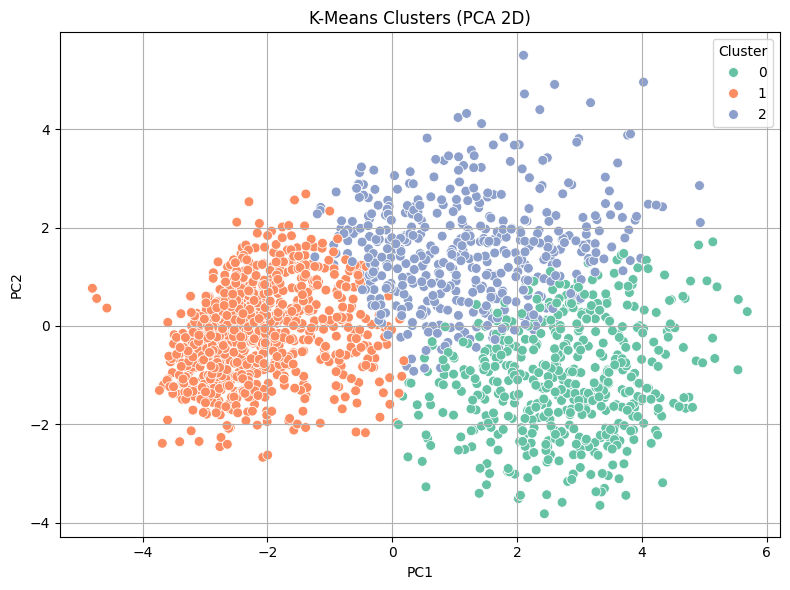

In [91]:
X_visu = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_visu[:,0], y=X_visu[:,1], hue=labels_kmeans, palette='Set2', s=50)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

Silhouette Score (k=3) : 0.257


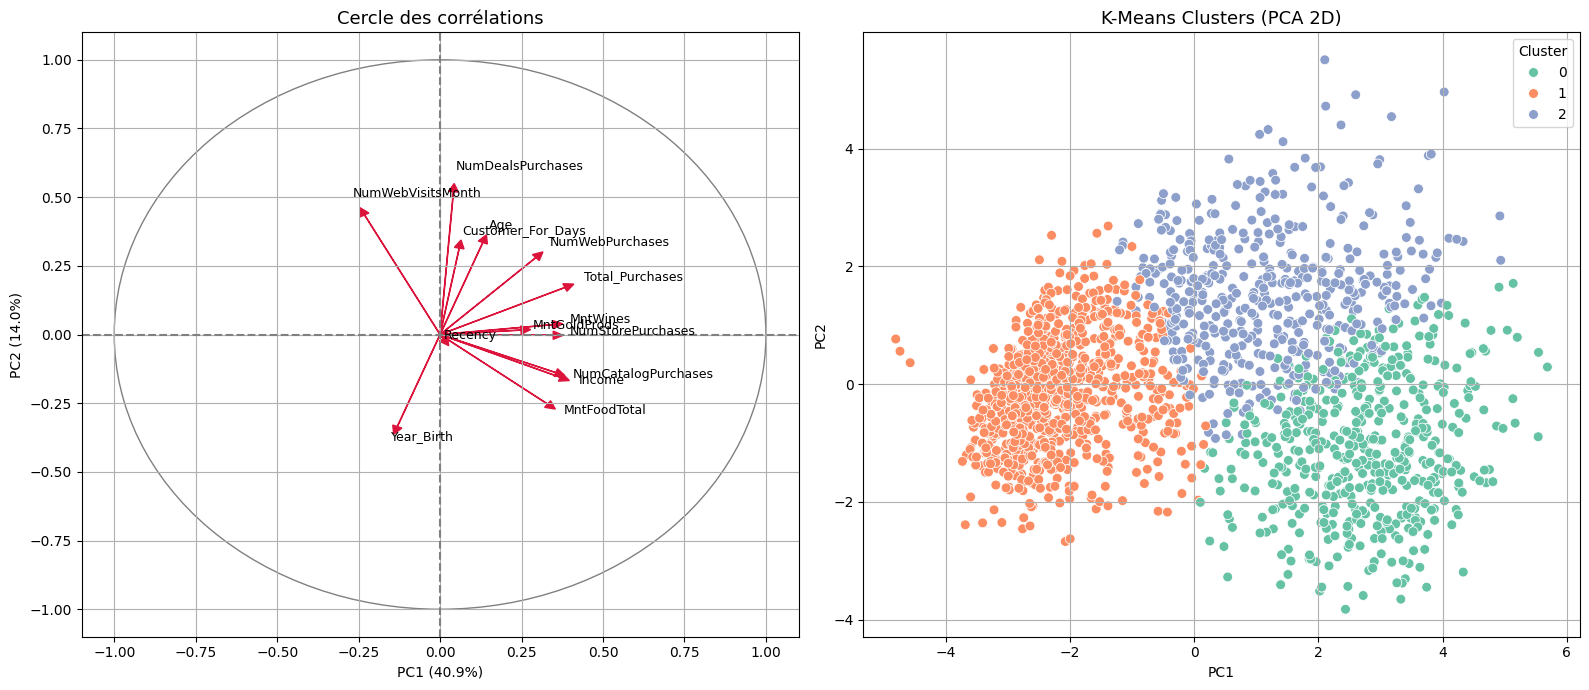

In [95]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
pc1 = pca.components_[0]
pc2 = pca.components_[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax1.add_artist(circle)

for i in range(len(X_scaled_df.columns)):
    x, y = pc1[i], pc2[i]
    ax1.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='crimson', ec='crimson')
    ax1.text(x * 1.15, y * 1.15, X_scaled_df.columns[i], fontsize=9)

ax1.axhline(0, color='grey', linestyle='--')
ax1.axvline(0, color='grey', linestyle='--')
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax1.set_title("Cercle des corrélations", fontsize=13)
ax1.grid(True)

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_kmeans,
    palette='Set2',
    s=50,
    ax=ax2
)
ax2.set_title("K-Means Clusters (PCA 2D)", fontsize=13)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(title="Cluster")
ax2.grid(True)

score = silhouette_score(X_scaled_df, labels_kmeans)
print(f"Silhouette Score (k=3) : {score:.3f}")

plt.tight_layout()
plt.show()


On peut voir que les visiteurs du Web sont à l'opposé du MntFoodTotal(ils ne passent pas à la boutique après avoir visualiser le site). Il faut donc penser à une refonte du site pour les faires passer en boutique

Interprétation rapide :

    1.0 → clusters très denses et bien séparés

    ~0.5 → structure correcte

    < 0.3 → clusters mal séparés (à surveiller)

### 3D

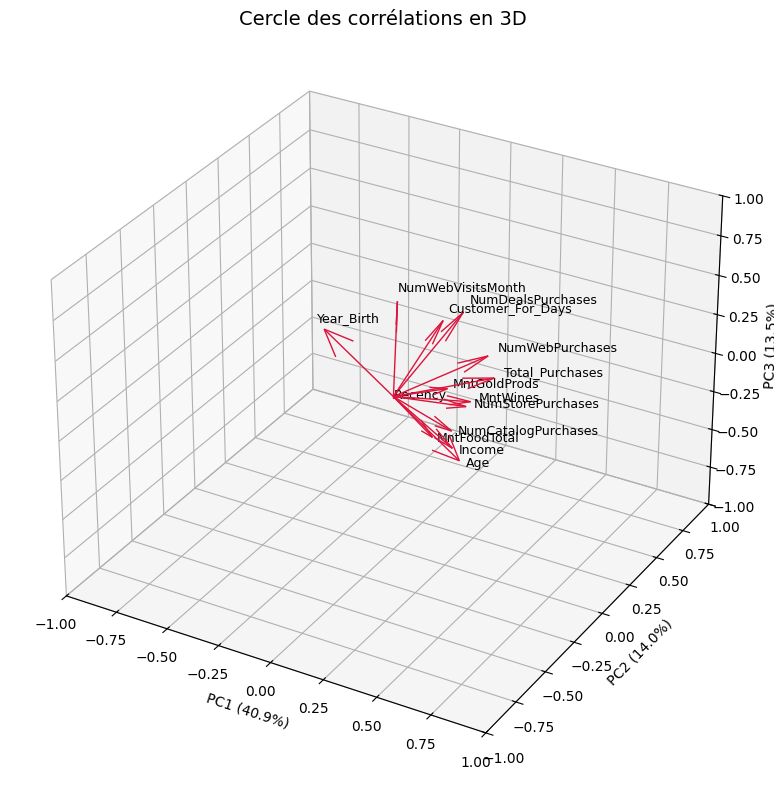

In [80]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled_df)
components = pca_3d.components_

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Flèches (vecteurs)
for i in range(len(X_scaled_df.columns)):
    x, y, z = components[0, i], components[1, i], components[2, i]
    ax.quiver(0, 0, 0, x, y, z, color='crimson', linewidth=1)
    ax.text(x * 1.1, y * 1.1, z * 1.1, X_scaled_df.columns[i], fontsize=9)

# Axes et labels
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)")
ax.set_title("Cercle des corrélations en 3D", fontsize=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_17879/494999403.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


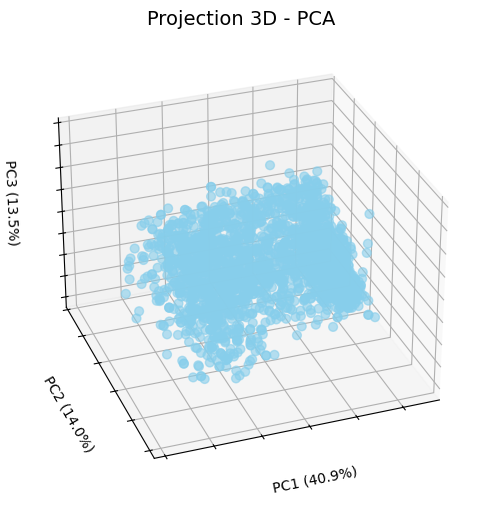

In [81]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled_df)

# Visualisation 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)

# Scatter plot (aucun label ici, tu peux utiliser un clustering ou autre pour colorier)
scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c='skyblue',  # ou remplace par `labels_kmeans` si disponible
    s=40,
    alpha=0.6
)

# Configuration des axes
ax.set_title("Projection 3D - PCA", fontsize=14)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.tight_layout()
plt.show()